In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle(1).json to kaggle(1).json


In [4]:
!mkdir -p ~/.kaggle
!cp "kaggle(1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d andrewmvd/drive-digital-retinal-images-for-vessel-extraction


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction
License(s): other
  0% 0.00/28.0M [00:00<?, ?B/s]
100% 28.0M/28.0M [00:00<00:00, 1.26GB/s]


In [6]:
!unzip drive-digital-retinal-images-for-vessel-extraction.zip


Archive:  drive-digital-retinal-images-for-vessel-extraction.zip
  inflating: DRIVE/test/images/01_test.tif  
  inflating: DRIVE/test/images/02_test.tif  
  inflating: DRIVE/test/images/03_test.tif  
  inflating: DRIVE/test/images/04_test.tif  
  inflating: DRIVE/test/images/05_test.tif  
  inflating: DRIVE/test/images/06_test.tif  
  inflating: DRIVE/test/images/07_test.tif  
  inflating: DRIVE/test/images/08_test.tif  
  inflating: DRIVE/test/images/09_test.tif  
  inflating: DRIVE/test/images/10_test.tif  
  inflating: DRIVE/test/images/11_test.tif  
  inflating: DRIVE/test/images/12_test.tif  
  inflating: DRIVE/test/images/13_test.tif  
  inflating: DRIVE/test/images/14_test.tif  
  inflating: DRIVE/test/images/15_test.tif  
  inflating: DRIVE/test/images/16_test.tif  
  inflating: DRIVE/test/images/17_test.tif  
  inflating: DRIVE/test/images/18_test.tif  
  inflating: DRIVE/test/images/19_test.tif  
  inflating: DRIVE/test/images/20_test.tif  
  inflating: DRIVE/test/mask/01_tes

In [7]:
import os
os.listdir("/content")

['.config',
 'kaggle(1).json',
 'drive-digital-retinal-images-for-vessel-extraction.zip',
 'DRIVE',
 'sample_data']

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola


In [9]:
base_path = "DRIVE"

for root, dirs, files in os.walk(base_path):
    print(f"\nFolder: {root}")
    print("Subfolders:", dirs)
    print("Number of files:", len(files))



Folder: DRIVE
Subfolders: ['training', 'test']
Number of files: 0

Folder: DRIVE/training
Subfolders: ['1st_manual', 'mask', 'images']
Number of files: 0

Folder: DRIVE/training/1st_manual
Subfolders: []
Number of files: 20

Folder: DRIVE/training/mask
Subfolders: []
Number of files: 20

Folder: DRIVE/training/images
Subfolders: []
Number of files: 20

Folder: DRIVE/test
Subfolders: ['mask', 'images']
Number of files: 0

Folder: DRIVE/test/mask
Subfolders: []
Number of files: 20

Folder: DRIVE/test/images
Subfolders: []
Number of files: 20


In [10]:
train_images = os.listdir("DRIVE/training/images")
test_images = os.listdir("DRIVE/test/images")

print("Number of training images:", len(train_images))
print("Number of test images:", len(test_images))


Number of training images: 20
Number of test images: 20


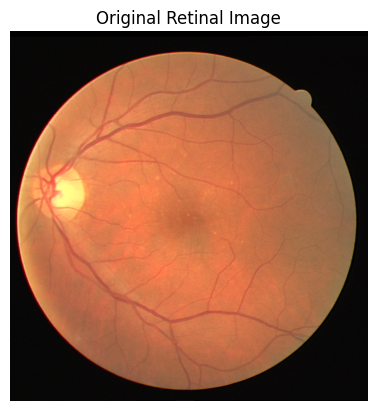

In [11]:
image_path = "DRIVE/training/images/21_training.tif"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Original Retinal Image")
plt.axis("off")
plt.show()


In [12]:
print("Image shape:", image_rgb.shape)
print("Data type:", image_rgb.dtype)
print("Minimum pixel value:", image_rgb.min())
print("Maximum pixel value:", image_rgb.max())


Image shape: (584, 565, 3)
Data type: uint8
Minimum pixel value: 0
Maximum pixel value: 255


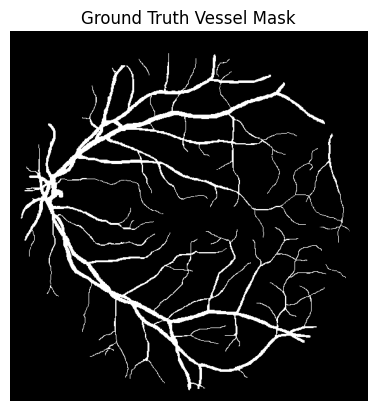

In [13]:
gt_path = "DRIVE/training/1st_manual/21_manual1.gif"
gt = cv2.imread(gt_path, 0)

plt.imshow(gt, cmap="gray")
plt.title("Ground Truth Vessel Mask")
plt.axis("off")
plt.show()


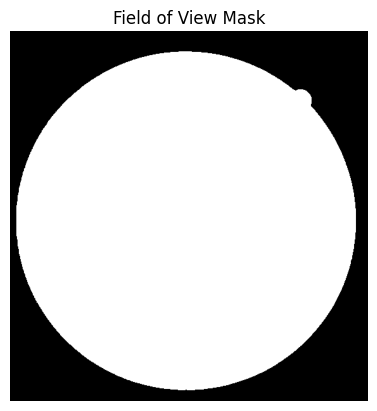

In [14]:
mask_path = "DRIVE/training/mask/21_training_mask.gif"
fov = cv2.imread(mask_path, 0)

plt.imshow(fov, cmap="gray")
plt.title("Field of View Mask")
plt.axis("off")
plt.show()


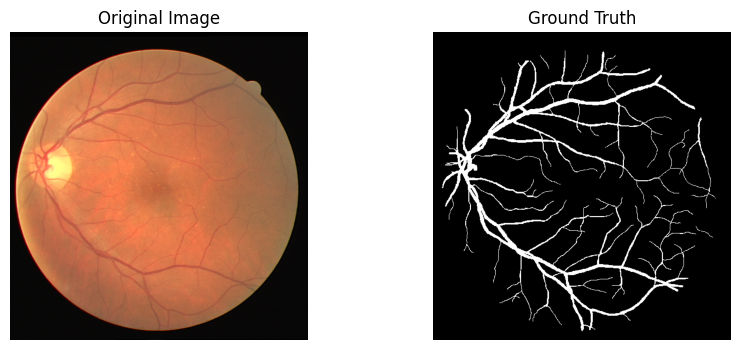

In [15]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.show()


In [17]:
import numpy as np

vessel_pixels = np.sum(gt > 0)
background_pixels = np.sum(gt == 0)

print("Vessel pixels:", vessel_pixels)
print("Background pixels:", background_pixels)
print("Vessel percentage:", vessel_pixels / (vessel_pixels + background_pixels))


Vessel pixels: 24658
Background pixels: 305302
Vessel percentage: 0.07473027033579828


In [18]:
def compute_sensitivity(pred, gt):
    # True Positive = vessel pixel correctly detected
    TP = np.sum((pred == 1) & (gt == 1))

    # False Negative = vessel pixel missed
    FN = np.sum((pred == 0) & (gt == 1))

    # Sensitivity = TP / (TP + FN)
    sensitivity = TP / (TP + FN + 1e-8)

    return sensitivity


In [19]:
# Paths for training set
train_img_dir = "DRIVE/training/images"
train_gt_dir = "DRIVE/training/1st_manual"
train_mask_dir = "DRIVE/training/mask"

# List of training images
image_list = sorted(os.listdir(train_img_dir))


In [34]:
niblack_sens = []
sauvola_sens = []

In [35]:
for img_name in image_list:
    # Load image
    img_path = os.path.join(train_img_dir, img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Image number (to match GT and mask files)
    number = img_name.split("_")[0]

    # Load ground truth
    gt_path = os.path.join(train_gt_dir, number + "_manual1.gif")
    gt = cv2.imread(gt_path, 0)
    gt_binary = gt > 0  # convert to binary

    # Load FOV mask
    mask_path = os.path.join(train_mask_dir, number + "_training_mask.gif")
    fov = cv2.imread(mask_path, 0)
    fov_binary = fov > 0  # convert to binary

    # Preprocessing: green channel + CLAHE
    green = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(green)

    # Niblack threshold
    thresh_n = threshold_niblack(enhanced, window_size=25, k=-0.2)
    binary_niblack = enhanced < thresh_n
    binary_niblack = binary_niblack & fov_binary

    # Sauvola threshold
    thresh_s = threshold_sauvola(enhanced, window_size=25, k=0.5)
    binary_sauvola = enhanced < thresh_s
    binary_sauvola = binary_sauvola & fov_binary

    # Apply FOV mask to GT
    gt_binary = gt_binary & fov_binary

    # Compute sensitivities
    sens_n = compute_sensitivity(binary_niblack, gt_binary)
    sens_s = compute_sensitivity(binary_sauvola, gt_binary)

    # Store results
    niblack_sens.append(sens_n)
    sauvola_sens.append(sens_s)

In [37]:
print("NIBLACK-")
print("Average Sensitivity:", np.mean(niblack_scores))

print("\nSAUVOLA-")
print("Average Sensitivity:", np.mean(sauvola_scores))

NIBLACK-
Average Sensitivity: 0.8932276050238475

SAUVOLA-
Average Sensitivity: 0.42707941962360796


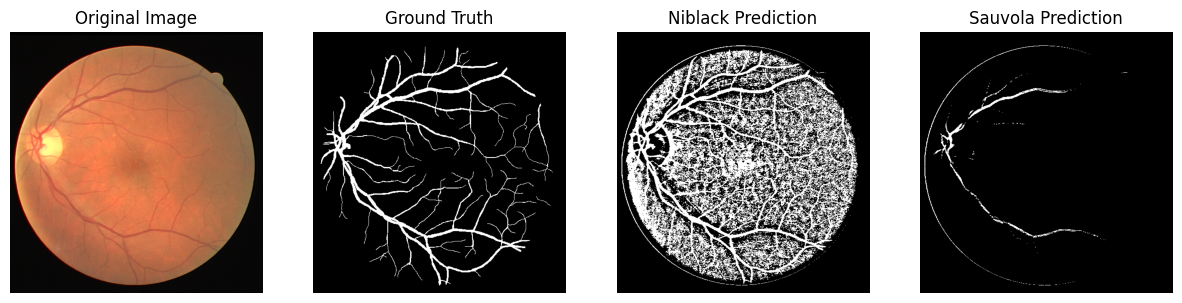

In [38]:
import matplotlib.pyplot as plt

# Pick a sample image from training set
sample_img_name = image_list[0]  # first image
img_path = os.path.join(train_img_dir, sample_img_name)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Image number to load GT and FOV mask
number = sample_img_name.split("_")[0]

# Load GT
gt_path = os.path.join(train_gt_dir, number + "_manual1.gif")
gt = cv2.imread(gt_path, 0)
gt_binary = gt > 0

# Load FOV mask
mask_path = os.path.join(train_mask_dir, number + "_training_mask.gif")
fov = cv2.imread(mask_path, 0)
fov_binary = fov > 0

# Preprocessing
green = image[:, :, 1]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(green)

# Niblack prediction
thresh_n = threshold_niblack(enhanced, window_size=25, k=-0.2)
binary_niblack = enhanced < thresh_n
binary_niblack = binary_niblack & fov_binary

# Sauvola prediction
thresh_s = threshold_sauvola(enhanced, window_size=25, k=0.5)
binary_sauvola = enhanced < thresh_s
binary_sauvola = binary_sauvola & fov_binary

# ---------------- Visualization ----------------
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(gt_binary, cmap='gray')
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(binary_niblack, cmap='gray')
plt.title("Niblack Prediction")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(binary_sauvola, cmap='gray')
plt.title("Sauvola Prediction")
plt.axis("off")

plt.show()
